# Learning Canonical Transformations from Trajectories of an Integrable Model

## Neumann Hamiltonian

We consider the integrable Hamiltonian

$$
H = \frac{1}{4}\sum_{\alpha,\beta} J_{\alpha\beta}^2 + \frac{1}{2}\sum_\alpha k_\alpha x_\alpha^2
$$

with $J_\alpha\beta = x_\alpha p_\beta - x_\beta p_\alpha$ is the (generalized) angular momentum. The constants of motion are

$$
I_\alpha = x_\alpha^2 + \sum_{\beta\neq \alpha} \frac{J_{\alpha\beta}^2}{k_\alpha-k_\beta}
$$

for $k_\alpha$ all different. We have

$$
H = \frac{1}{2}\sum_\alpha k_\alpha I_\alpha
$$

And

$$
\sum_\alpha x_\alpha^2 = \sum_\alpha I_\alpha,
$$

so that motion is confined to the sphere $S^{N-1}$.

## Equations of Motion

The equations of motion have Hamiltonian form

$$
\begin{align}
\dot p_\alpha &= \frac{\partial H}{\partial x_\alpha} = -k_\alpha x_\alpha-\sum_\beta \left[x_\alpha p_\beta-x_\beta p_\alpha\right]p_\beta\\
\dot x_\alpha &= -\frac{\partial H}{\partial p_\alpha} = \sum_\beta \left[p_\alpha x_\beta-p_\beta x_\alpha\right]x_\beta
\end{align}
$$

In [1]:
import sys
sys.path.append("../")
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

In [2]:
from hamiltonians import parameterized_neumann
from models import NICE, SymplecticExchange, SqueezeAndShift, Chain, MLP, IrrotationalMLP
from utils import visualize_chain_bijector_1d, extract_q_p, is_symplectic, run_eagerly

In [3]:
# tf.enable_eager_execution()
sess = tf.InteractiveSession()
tf.set_random_seed(0)

## Sample solution in TF

In [4]:
N = 3

In [5]:
ks = [0.9743002 , 0.15526697, 0.46813834] # Just to fix some values
ks_tensor = tf.constant(ks, dtype=tf.float32, name="ks")

In [6]:
def join_q_p(qs, ps):
    qs = tf.expand_dims(qs, axis=1)
    ps = tf.expand_dims(ps, axis=1)
    return tf.reshape(tf.concat([qs,ps], axis=1), [-1])

In [7]:
def neumann_system(ks):
    def neumann_equations(phase_space_point, t):
        xs, ps = phase_space_point[::2], phase_space_point[1::2]
        dps = - ks * xs
        dps += -xs * tf.reduce_sum(ps**2)
        dps += ps * tf.reduce_sum(xs * ps)
        dxs = ps * tf.reduce_sum(xs**2)
        dxs += - xs * tf.reduce_sum(xs * ps)
        return join_q_p(dxs, dps)
    return neumann_equations

In [8]:
def neumann_batch(ks, size):
    N = ks.shape.as_list()[0]
    init_state = tf.random_uniform([2*N])
    t = tf.linspace(0.0, 100.0, num=size)
    tensor_state, tensor_info = tf.contrib.integrate.odeint(neumann_system(ks), init_state, t, full_output=True)
    return tensor_state

In [9]:
state = sess.run(neumann_batch(ks_tensor, 200))
x, px, y, py, z, pz = state.T

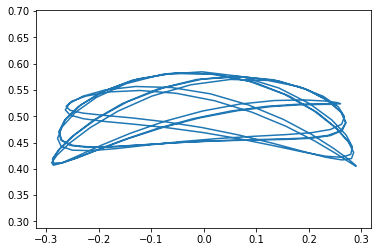

In [10]:
plt.axes().set_aspect('equal', 'datalim')
plt.plot(x, y)

## Check the integrals of motion

In [11]:
def Is(phase_space_point):
    xs, ps = phase_space_point[::2], phase_space_point[1::2]
    Is = xs**2 
    for α, _ in enumerate(Is):
        for β, _ in enumerate(Is):
            J = xs[α]*ps[β] - ps[α]*xs[β]
            if β != α:
                Is[α] += J**2 / (ks[α] - ks[β])
    return Is

In [12]:
I_traj = np.array([Is(point) for point in state])

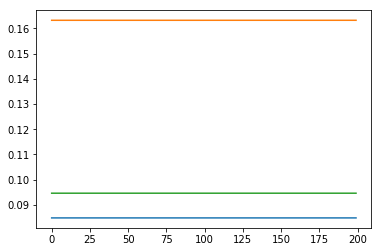

In [13]:
plt.plot(I_traj)

Check the imlementation of the Neumann Hamiltonian yields correct value

In [14]:
neumann_hamiltonian = parameterized_neumann(ks_tensor)

In [15]:
init_state = tf.random_uniform([2*N])
sess.run(neumann_hamiltonian(tf.reshape(init_state, (1,-1,1))))

array([[[0.26650888]]], dtype=float32)

In [16]:
np.sum(ks*Is(sess.run(init_state))) / 2

0.6586767312780701

## Form Transformation by Chaining Bijectors

The idea is to map _from_ trajectories _to_ the phase plane of action angle variables, imposing the condition that the distribution factorizes.

In [17]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [18]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': parameterized_neumann(ks), 
    'phase_space_dim': 2*N, 
    'batch_size': 256,    # Mini batch size 
    'num_bijectors': 8,   # Number of bijectors
    'train_iters': 1e5}   # Number of training iterations

Here we try modeling with `IrrotationalMLP`, which directly generates an irrotational vector field, without using autodifferentiation.

There is freedom to choose different activations here. Could use traditional NN nonlinearities or simpler things like `tf.square`.

In [19]:
with tf.variable_scope("transform"):
    bijectors = [SqueezeAndShift(shift_model=IrrotationalMLP(tf.nn.softplus)) if i % 2 == 0 
             else SymplecticExchange() 
             for i in range(settings['num_bijectors'])]
    model = Chain(bijectors)

## Form the Loss

The temperatures of the GGE distributions must be learned, but we must ensure they are positive

In [20]:
sqrt_betas = tf.get_variable("betas", shape=[1,N,1], dtype=DTYPE)
sqrt_betas_doubled = tf.tile(sqrt_betas, [1,1,2])

Accounting for the normalization, the log probability is

$$
\log p = -\sum_j \left[\beta_j \left(q_j^2+p_j^2\right)-\log (\beta_j/\pi)\right]
$$

__I've messed this up many times in implementation, so it's probably worth checking__

In [21]:
# with tf.variable_scope("loss"):
#     z_samples = tf.expand_dims(neumann_batch(ks_tensor, settings['batch_size']), -1)
#     q, p = extract_q_p(model(z_samples))
#     z_doubled = tf.concat([q, p], 2)
#     loss = tf.reduce_mean(tf.square(z_doubled * sqrt_betas_doubled) - tf.log(sqrt_betas_doubled**2) / 2)

An alternative loss would be to ask that the (squared) radius of each variable doesn't fluctuate, so the loss is just the sum of the variances of the squared radii. The idea is to force the radial variables to be conserved.

In [22]:
with tf.variable_scope("loss"):
    z_samples = tf.expand_dims(neumann_batch(ks_tensor, settings['batch_size']), -1)
    q, p = extract_q_p(model(z_samples))
    z_doubled = tf.concat([q, p], 2)
    square_radii = tf.reduce_sum(tf.square(z_doubled), axis=2)
    var_square_radii = tf.reduce_mean(tf.square(square_radii), axis=0) - tf.square(tf.reduce_mean(square_radii, axis=0))
    loss = tf.reduce_mean(var_square_radii)

## Train

In [23]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step=step)

Add some summaries for tracking with TensorBoard

In [24]:
tf.summary.scalar("loss_function", tf.reshape(loss, []))
# tf.summary.scalar("mean_beta", tf.reshape(tf.reduce_mean(sqrt_betas**2), []))

<tf.Tensor 'loss_function:0' shape=() dtype=string>

Monitor training with `tensorboard --logdir logging/`

In [25]:
tf.contrib.training.train(train_op, logdir="../logging", save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 1.87836
INFO:tensorflow:Saving checkpoints for 112 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 1.79742
INFO:tensorflow:Saving checkpoints for 224 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.04533
INFO:tensorflow:Saving checkpoints for 347 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.16581
INFO:tensorflow:Saving checkpoints for 476 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.08062
INFO:tensorflow:global_step/sec: 2.36661
INFO:tensorflow:Saving checkpoints for 612 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.21731
INFO:tensorflow:Saving checkpoints for 745 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.11582
INFO:tensorfl

INFO:tensorflow:Saving checkpoints for 4304 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.27754
INFO:tensorflow:Saving checkpoints for 4439 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.15702
INFO:tensorflow:Saving checkpoints for 4534 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 0.619217
INFO:tensorflow:Saving checkpoints for 4651 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 1.83139
INFO:tensorflow:Saving checkpoints for 4750 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 1.82217
INFO:tensorflow:Saving checkpoints for 4877 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.1425
INFO:tensorflow:global_step/sec: 2.21116
INFO:tensorflow:Saving checkpoints for 5009 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.23065
INFO:tensorflow:Saving checkpoints for 5141 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 2.09321
INFO:tensorflow:Saving checkpoints for 5269 into ../log

KeyboardInterrupt: 

## Look at the Learned Representation

Load the saved model. If not training, first evaluate all cells _except_ for those in the __Train__ section. 

In [26]:
traindir = "../logging"
saver = tf.train.Saver()

In [27]:
ckpt_state = tf.train.get_checkpoint_state(traindir)
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ../logging/model.ckpt-6185


How do the trajectories look in the phase planes of the new variables?

In [36]:
transformed_traj = sess.run(model(z_samples))[:,:,0]
# transformed_traj = sess.run(z_samples)[:,:,0]
x1, y1, x2, y2, x3, y3 = transformed_traj.T

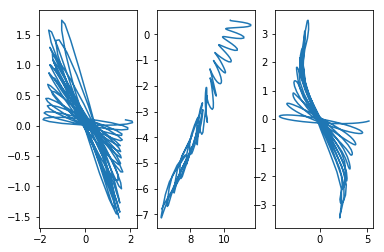

In [37]:
plt.subplot(1, 3, 1)
plt.plot(x1, y1)

plt.subplot(1, 3, 2)
plt.plot(x2, y2)

plt.subplot(1, 3, 3)
plt.plot(x3, y3)